In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [225]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a fictitious potential

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

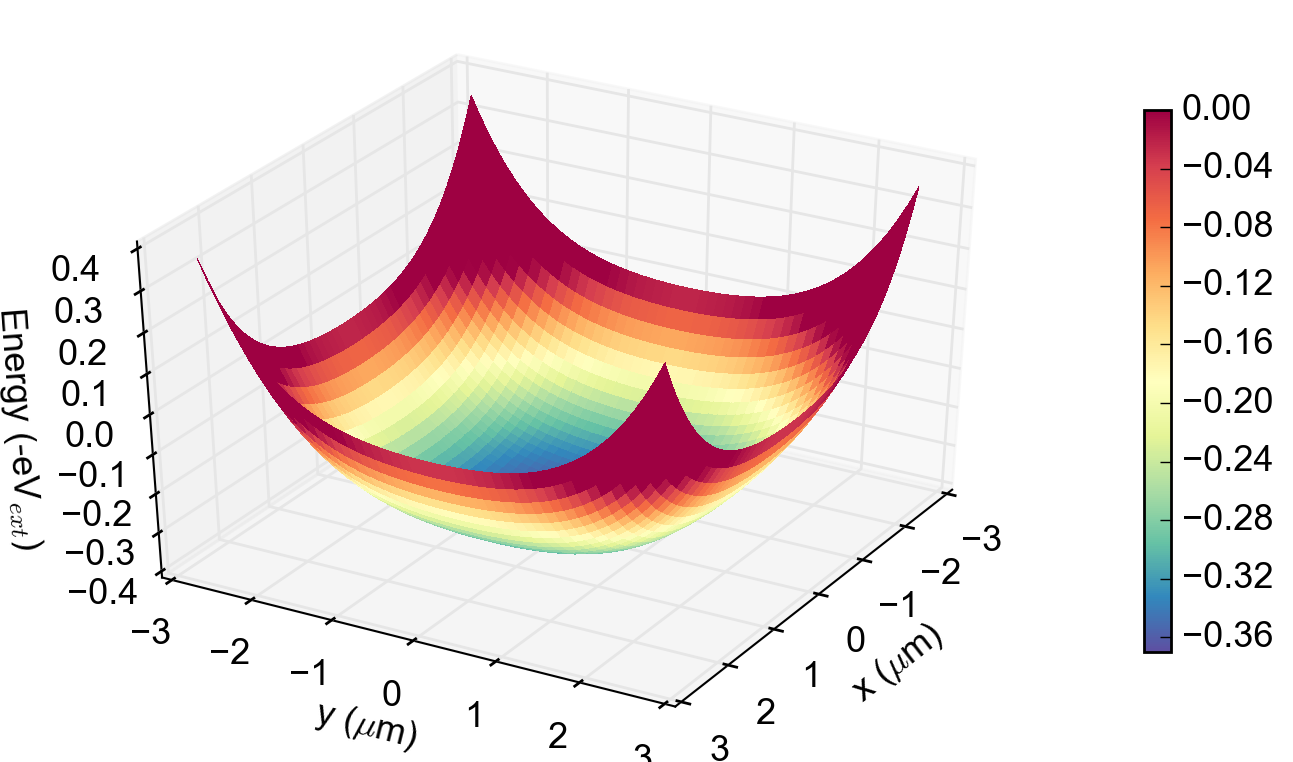

In [183]:
%matplotlib inline

gc = trap_analysis.get_constants()
resV = 0.5
save = True
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/50 electrons"

def Vext(xi, yi):
    # Offset
    a = 0.74
    # Curvatures in x-direction
    b = -7.0E-3 * 5.0E12
    c = -1.8E-3 * 5.0E24
    # Curvature in y-direction
    beta = -7.0E-3 * 5.0E12
    gamma = -1.8E-3 * 5.0E24
    return - gc['e'] * resV * (a + b*xi**2 + c*xi**4 + beta*yi**2 + gamma*yi**4)

xeval = np.linspace(-2.7E-6, 2.7E-6)
yeval = np.linspace(-2.7E-6, 2.7E-6)
X, Y = np.meshgrid(xeval, yeval)

fig = plt.figure(figsize=(7.,4.))
common.configure_axes(13)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X*1E6, Y*1E6, Vext(X,Y)/gc['e'], rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                       linewidth=0, antialiased=False, vmax=0.0)
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
ax.set_zlabel("Energy (-eV$_{ext}$)")
ax.view_init(elev=35., azim=30)
fig.colorbar(surf, shrink=0.75, aspect=20)
plt.tight_layout()
#fig.subplots_adjust(bottom=0.1, right=0.1)

if save: 
    common.save_figure(fig, save_path=save_path)

Just to keep track of all the speeds we want to see how fast the function evaluation is for the external potential.

In [146]:
%timeit np.sum(Vext(np.linspace(0, 1, 21), np.linspace(0, 1, 21)))

The slowest run took 4.94 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 28.5 µs per loop


In [147]:
def Velectrons(ri, eps=1E-15):
    """
    Returns the repulsion potential between two electrons separated by a distance sqrt(|xi-xj|**2 + |yi-yj|**2)
    Note the factor 1/2. in front of the potential energy to avoid overcounting.
    """
    Xi, Yi = np.meshgrid(ri[::2], ri[1::2])
    Xj, Yj = Xi.T, Yi.T
    
    Rij = np.sqrt((Xi-Xj)**2 + (Yi-Yj)**2)
    np.fill_diagonal(Rij, eps)
    
    return + 1/2. * gc['e']**2/(4*np.pi*gc['eps0']) * 1/Rij

def Vtotal(r):
    """
    Returns the total energy of N electrons
    r is a 0D array with coordinates of the electrons, in the form 
    r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
    The x-coordinates are thus given by the even elements of r: r[::2], 
    whereas the y-coordinates are the odd ones: r[1::2]
    """
    Vtot = np.sum(Vext(r[::2], r[1::2]))
    interaction_matrix = Velectrons(r)
    np.fill_diagonal(interaction_matrix, 0)
    Vtot += np.sum(interaction_matrix)
    return Vtot/gc['e']

def plot_Vtotal(x, y, electron_positions):
    Vtot = len(electron_positions) * Vext(x)
    for n, xn in enumerate(electron_positions):
        Vtot += 2*Velectrons(x, xn)
    return Vtot/gc['e']

def r2xy(r):
    x = r[::2]
    y = r[1::2]
    return x, y

def xy2r(x, y):
    if len(x) == len(y):
        r = np.zeros(2*len(x))
        r[::2] = x
        r[1::2] = y
        return r
    else:
        raise ValueError("x and y must have the same length!")
        return None

Here are the parameters of the simulation. I arrange the electrons in a circle of radius `initial_radius`. The number of electrons can be tweaked by changing `N_electrons`

In [ ]:
N_electrons = 100
initial_radius = 2.5E-6

xinit = initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/N_electrons)
yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/N_electrons)
electron_initial_positions = xy2r(xinit, yinit)

We can now evaluate the total potential at the initial positions of the electrons. This gives us an idea of the number we see when we start the minimization procedure. 

In [163]:
Vtotal(electron_initial_positions)

-9.3774619618610853

This number will always go down when we start the minimization (per definition). Let's find out how fast the function call is for the total energy:

In [168]:
%timeit Vtotal(electron_initial_positions)

In [158]:
class ConvergenceMonitor:
    def __init__(self, N=2500, verbose=True):
        self.call_every = N
        self.call_counter = 0
        self.verbose = verbose
        self.curr_func_val = list()
        self.func_calls = list()
        self.save_path = r"/Users/gkoolstra/Desktop/Electron optimization"
    
    def monitor_convergence(self, xk):
        
        if not(self.call_counter%self.call_every):
            self.func_calls.append(self.call_counter)
            self.curr_func_val.append(Vtotal(xk))
            if self.verbose:
                print("%d - function value: %.8f"%(self.call_counter, self.curr_func_val[-1]))
            
        self.call_counter += 1 
    
    def save_pictures(self, xk):
        
        fig = plt.figure(figsize=(4.225, 4.))
        plt.plot(xk[::2]*1E6, xk[1::2]*1E6, 'o', color='deepskyblue')
        plt.xlabel("$x$ ($\mu$m)")
        plt.ylabel("$y$ ($\mu$m)")
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        
        fig.savefig(os.path.join(self.save_path, '%.5d.png'%(self.call_counter)), bbox_inches='tight')
        
        self.monitor_convergence(xk)
        
    def create_movie()
        curr_dir = os.getcwd()
        os.chdir(self.save_path)
        os.system(r"ffmpeg -r 5 -b 1800 -i %05d.png movie.mp4")
        os.chdir(curr_dir)

Here is the actual minimization. First we set the matplotlib to Agg to suppress any plots that may come up. For callback we can choose `monitor_convergence` for simply printing the total energy every `N` iterations. We can also choose `save_pictures` to create a movie afterwards. The latter also prints the function value every `N` iterations. 

0 - function value: -25.76297485
10 - function value: -27.29321562
20 - function value: -27.38599016
30 - function value: -27.38804017
40 - function value: -27.38855337
50 - function value: -27.38863576
60 - function value: -27.38901755
         Current function value: -27.389018
         Iterations: 61
         Function evaluations: 78389
         Gradient evaluations: 388


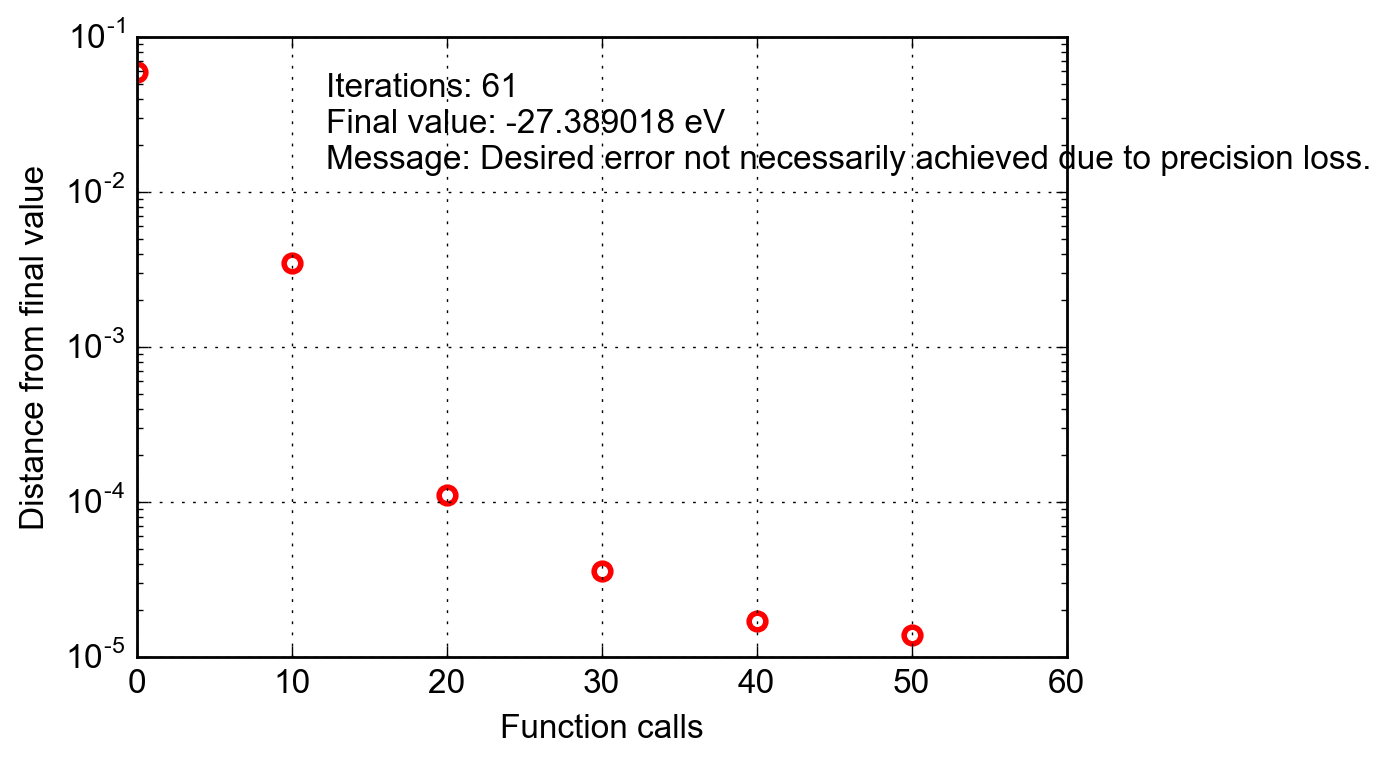

In [193]:
ConvMon = ConvergenceMonitor(verbose=True, N=10)
            
res = minimize(Vtotal, electron_initial_positions, method='CG', 
               options={'disp': True, 'maxiter' : 1E6}, tol=1E-6, 
               callback=ConvMon.monitor_convergence)

x, y = r2xy(res['x'])

figgy = plt.figure(figsize=(6.,4.))
common.configure_axes(12)
plt.plot(ConvMon.func_calls, np.abs((ConvMon.curr_func_val - res['fun'])/res['fun']), 
         'o', **common.plot_opt('red', style='translucent'))
plt.xlabel("Function calls")
plt.ylabel("Distance from final value")
plt.yscale('log')
plt.text(0.2*res['nit'], np.abs((ConvMon.curr_func_val[0] - res['fun'])/res['fun']), 
         "Iterations: %d\nFinal value: %.6f eV\nMessage: %s"%(res['nit'], res['fun'], res['message']), 
         wrap=True, ha='left', va='top')
plt.grid()

if save: 
    common.save_figure(figgy, save_path=save_path)

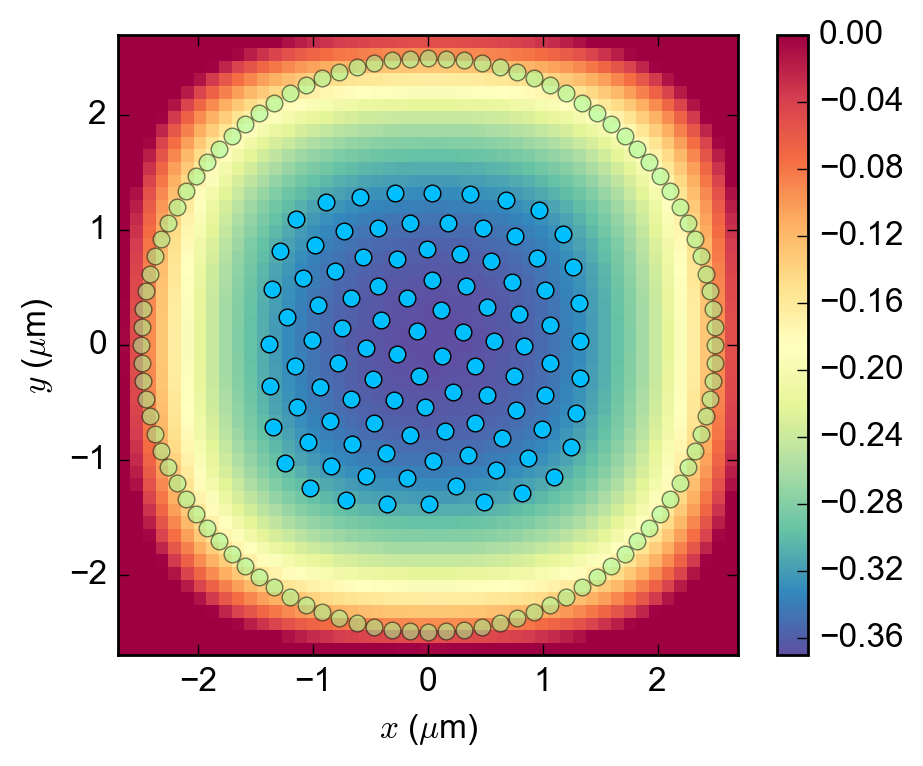

In [203]:
%matplotlib inline
figgy = plt.figure(figsize=(5,4))
common.configure_axes(12)
plt.pcolormesh(X*1E6, Y*1E6, Vext(X,Y)/gc['e'], cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.xlim(-2.7, 2.7)
plt.ylim(plt.xlim())
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

What follows is a benchmark

In [219]:
reload(diagnose)

<module 'BEMHelper.diagnose' from '/Users/gkoolstra/Documents/Code/BEMHelper/diagnose.py'>

In [220]:
from BEMHelper import diagnose

Timer class initiated
         Current function value: -3.548441
         Iterations: 12
         Function evaluations: 2147
         Gradient evaluations: 97
Total time elapsed is 1.66e-01 s
         Current function value: -6.853823
         Iterations: 27
         Function evaluations: 9675
         Gradient evaluations: 230
Total time elapsed is 9.04e-01 s
         Current function value: -11.455298
         Iterations: 49
         Function evaluations: 11820
         Gradient evaluations: 164
Total time elapsed is 1.22e+00 s
         Current function value: -15.678594
         Iterations: 63
         Function evaluations: 41631
         Gradient evaluations: 408
Total time elapsed is 4.73e+00 s
         Current function value: -19.558730
         Iterations: 116
         Function evaluations: 49777
         Gradient evaluations: 377
Total time elapsed is 7.11e+00 s
         Current function value: -23.116341
         Iterations: 71
         Function evaluations: 110011
         Gr

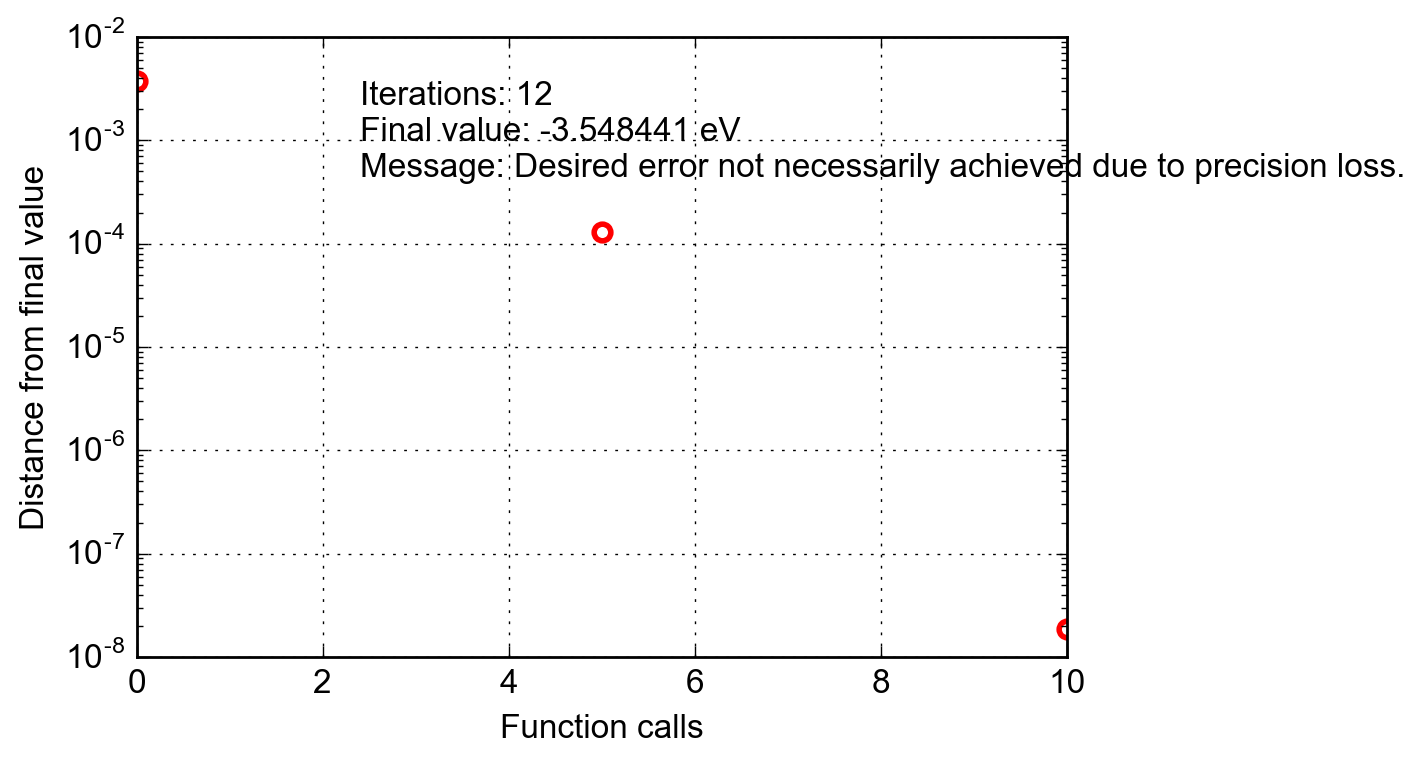

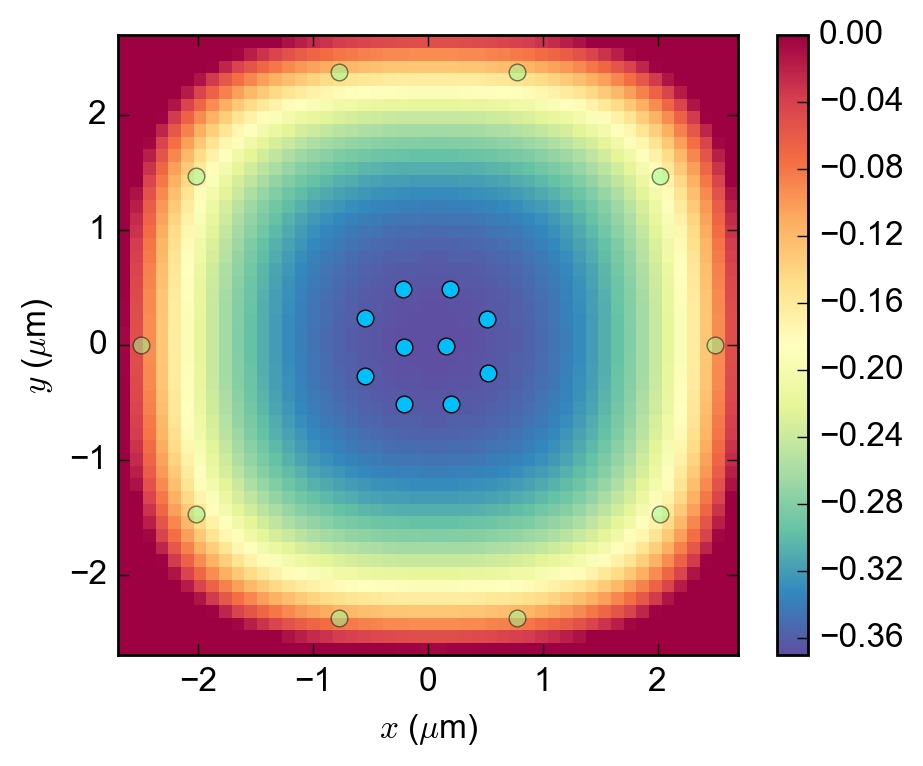

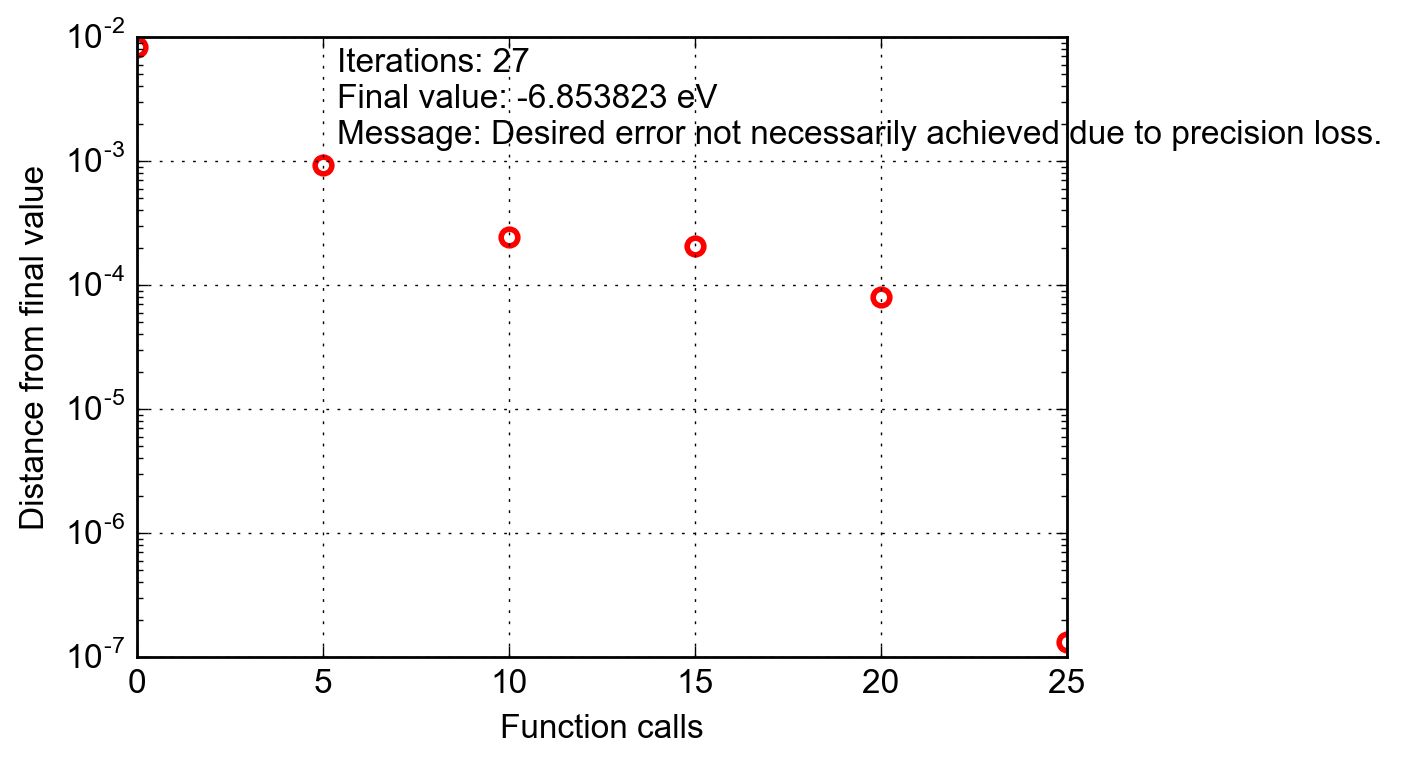

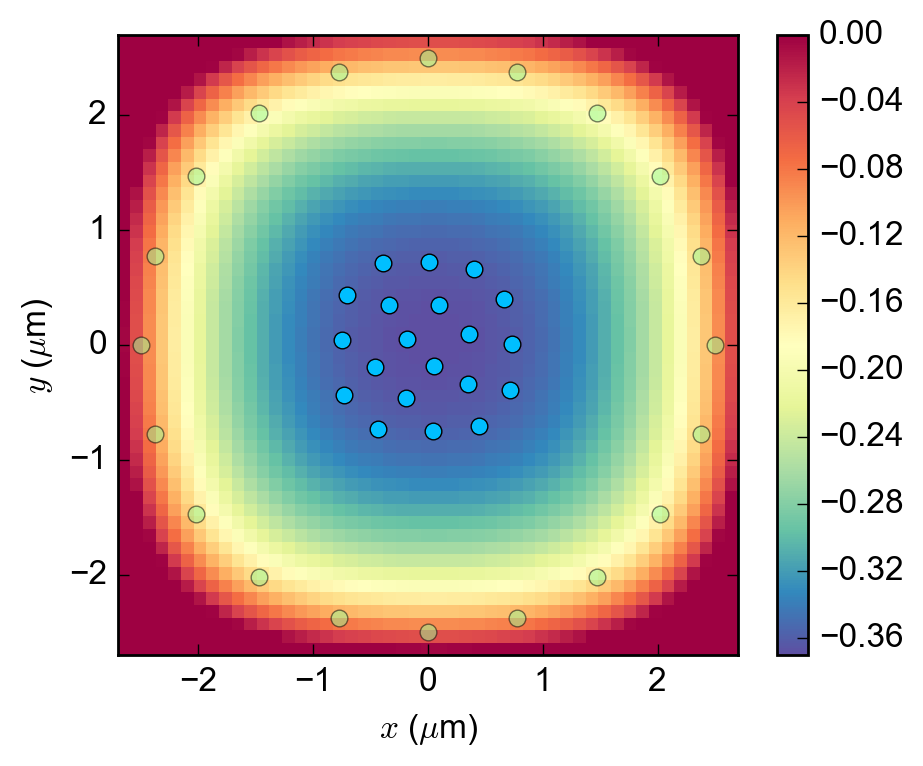

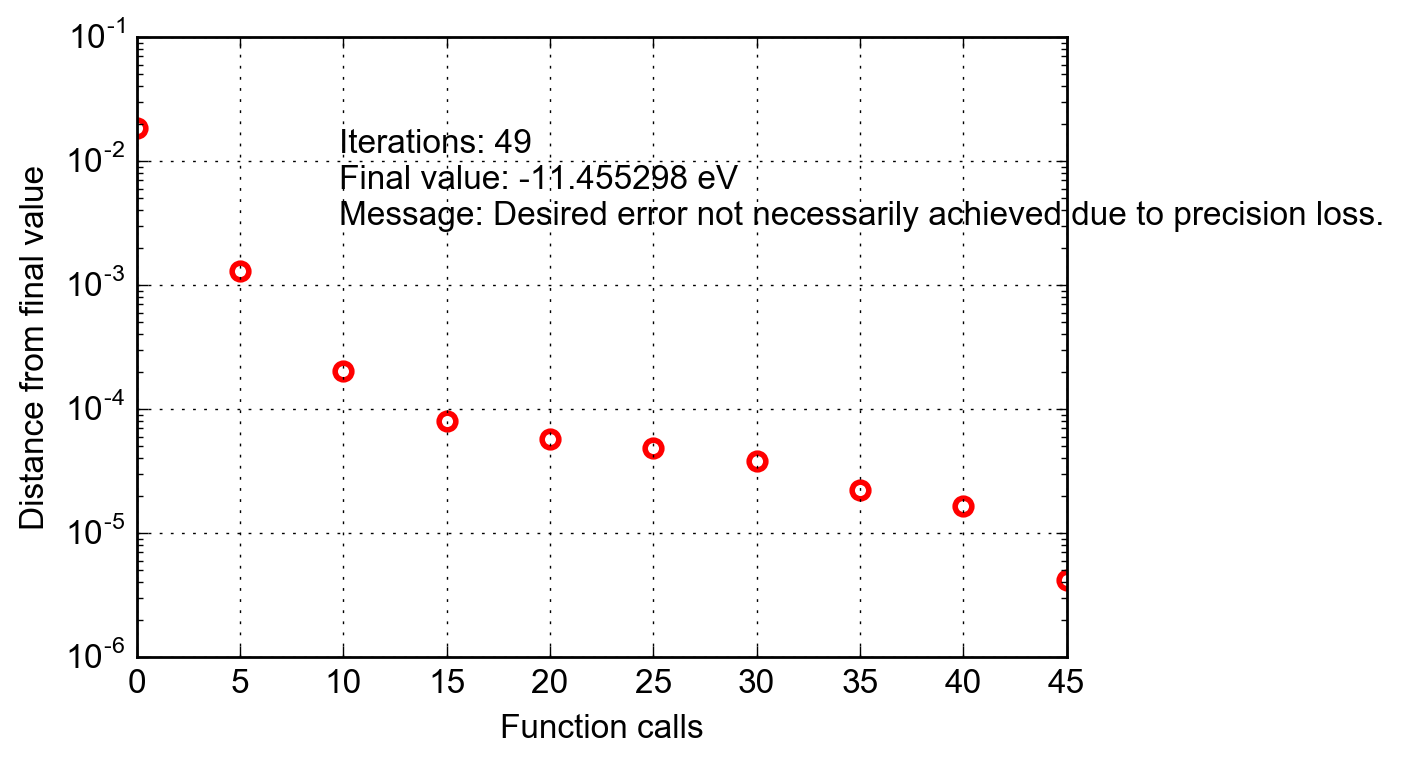

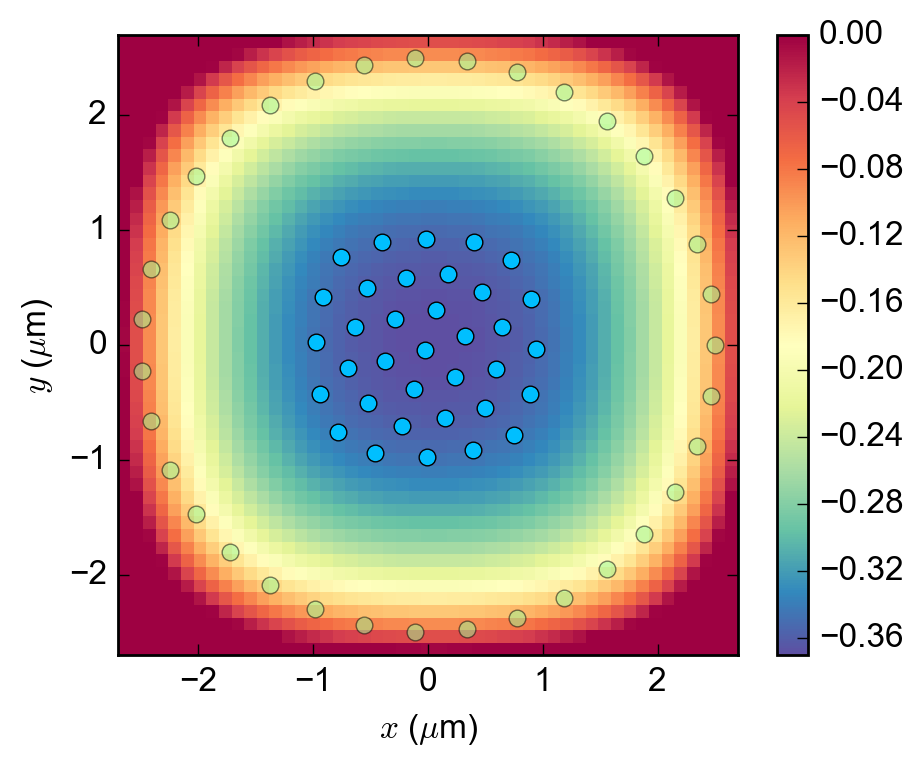

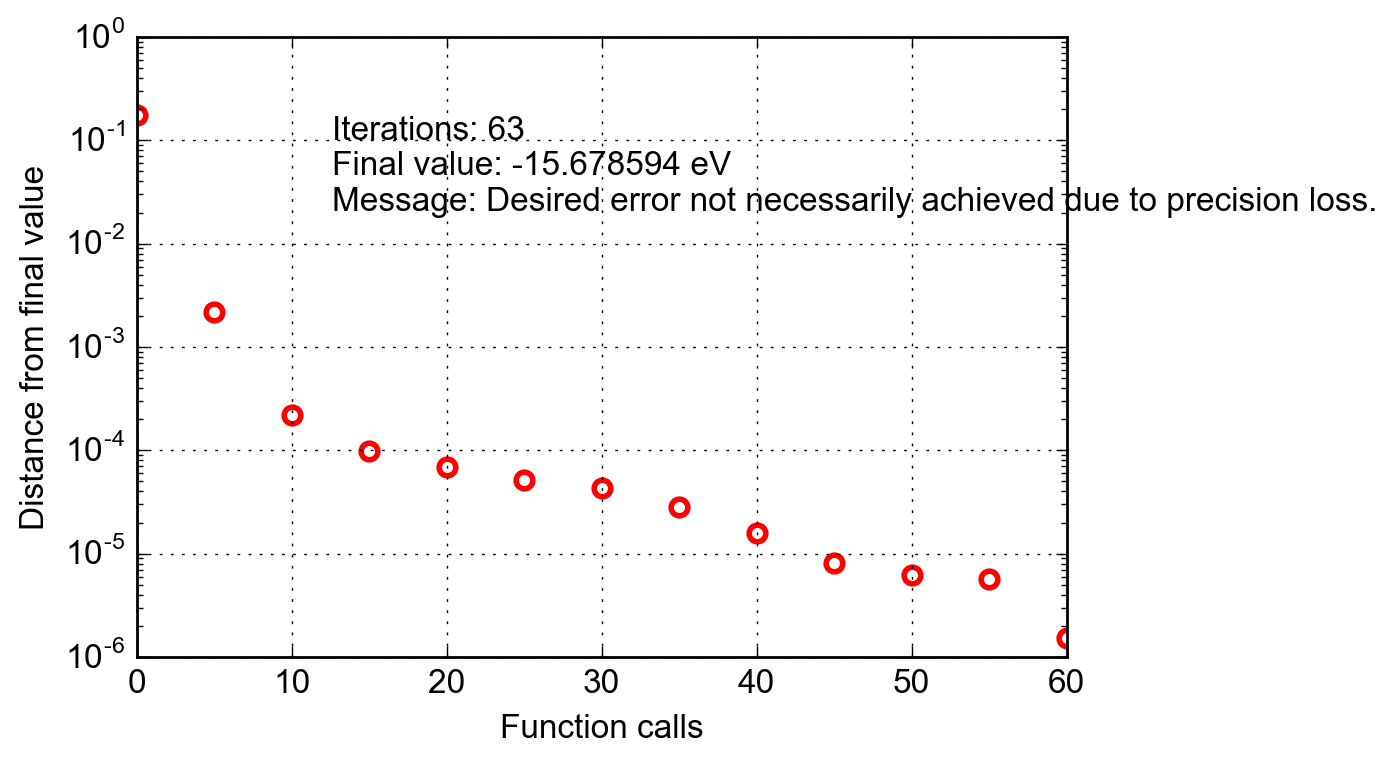

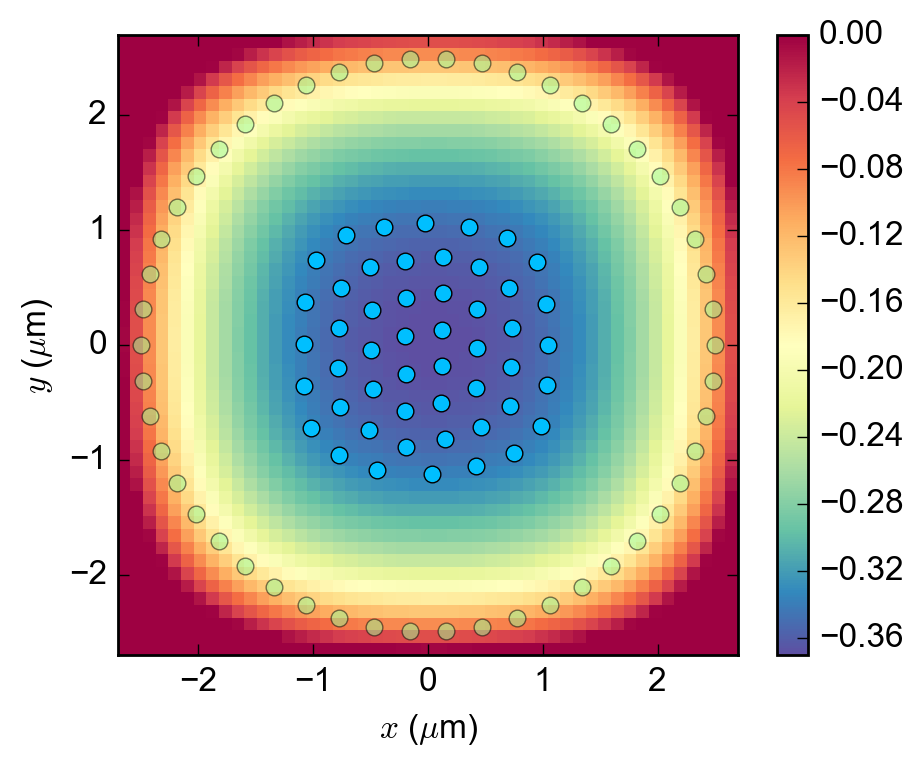

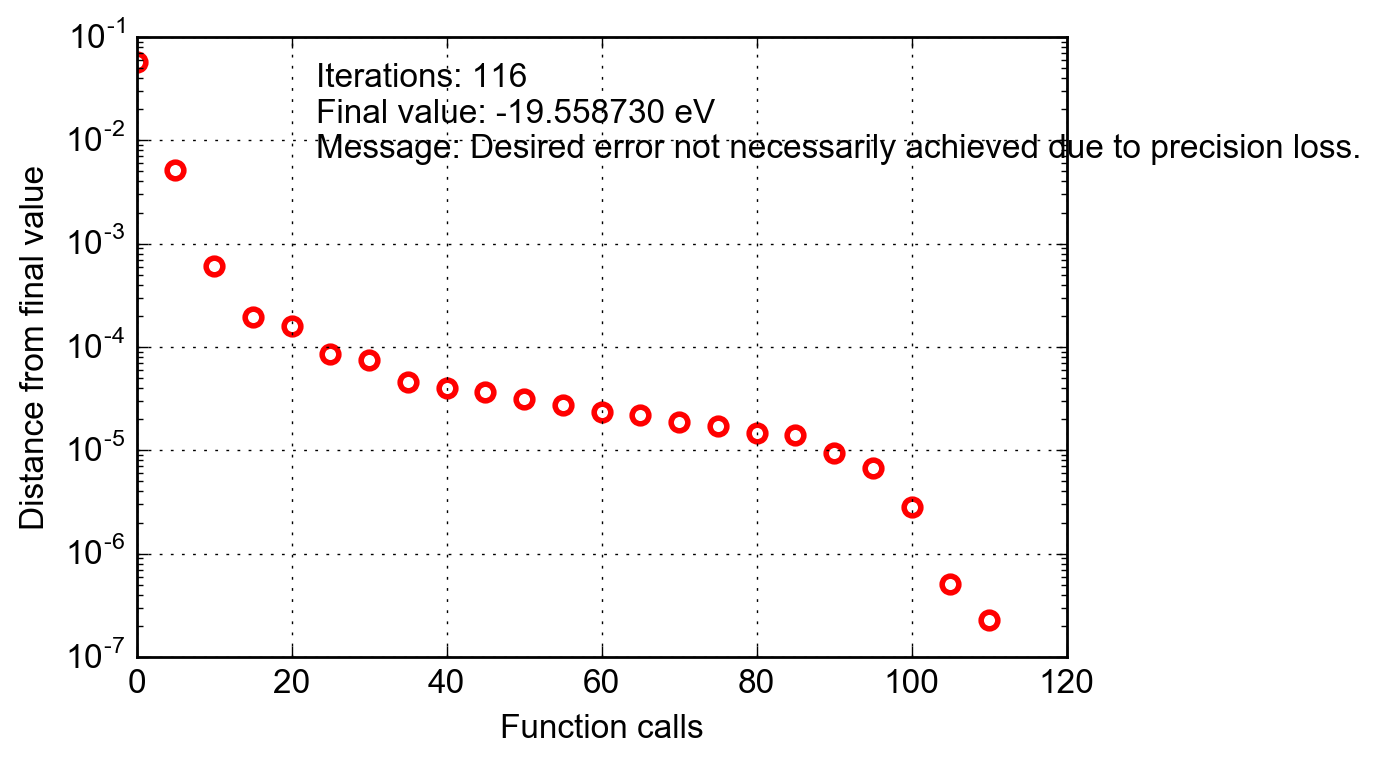

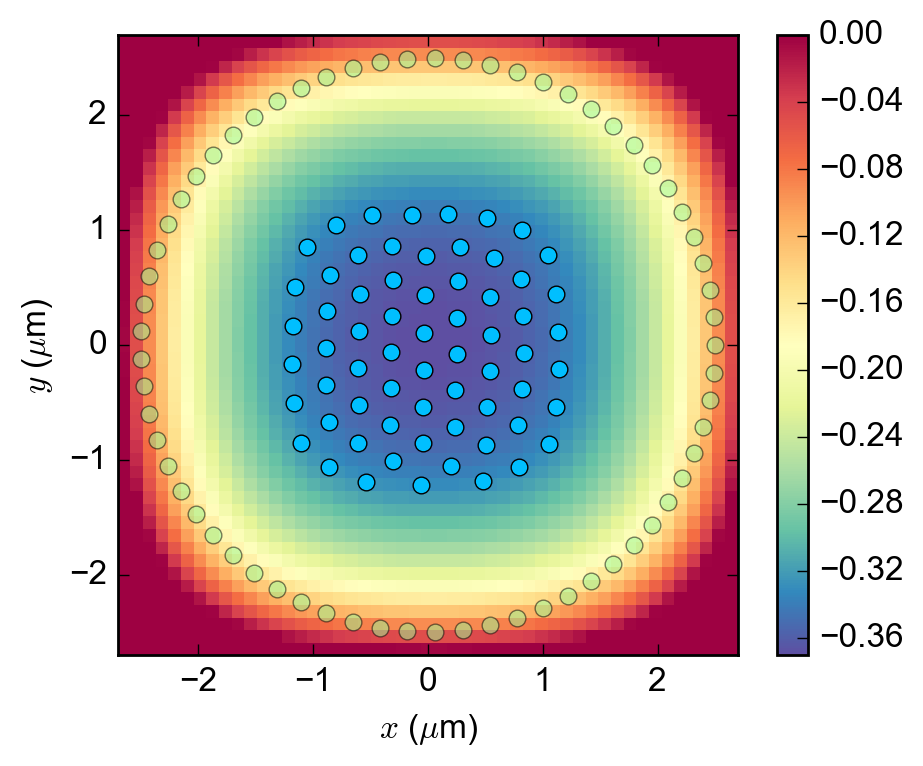

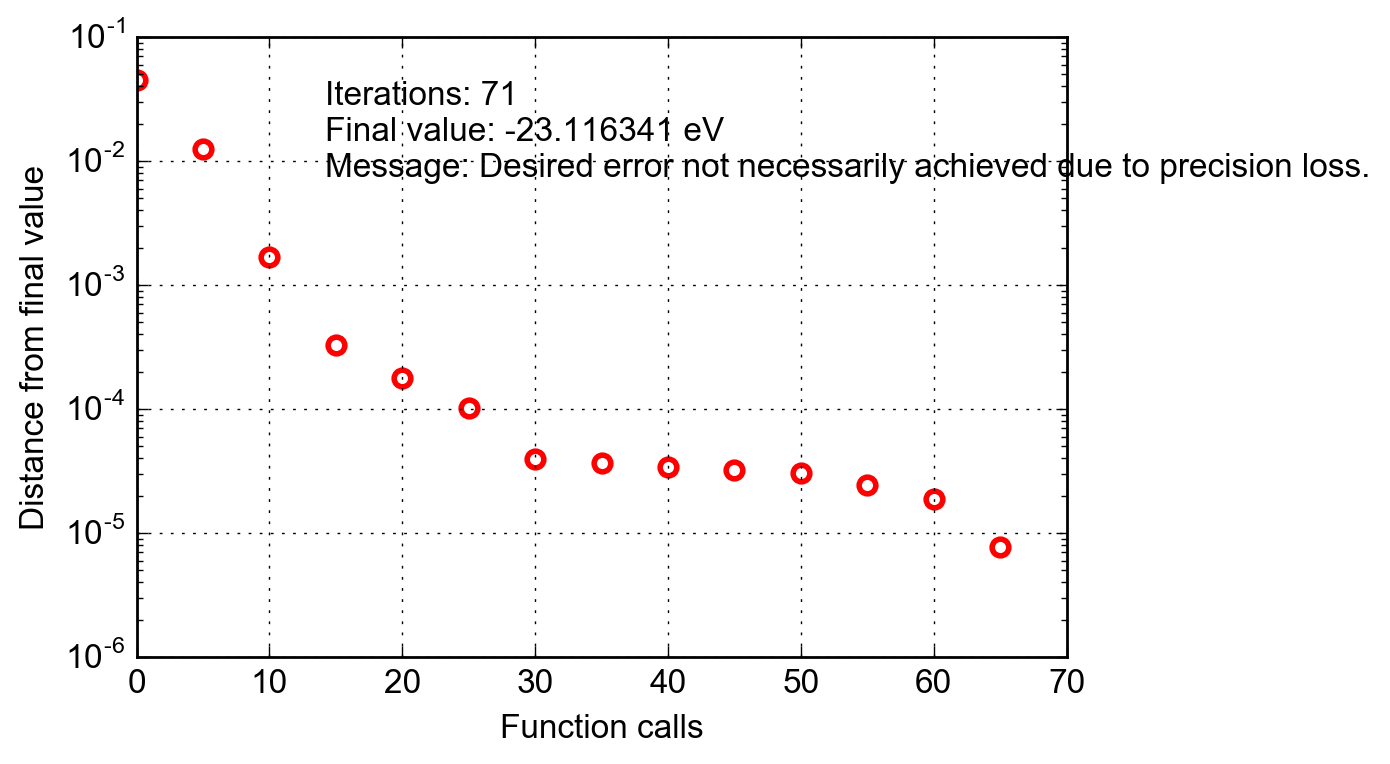

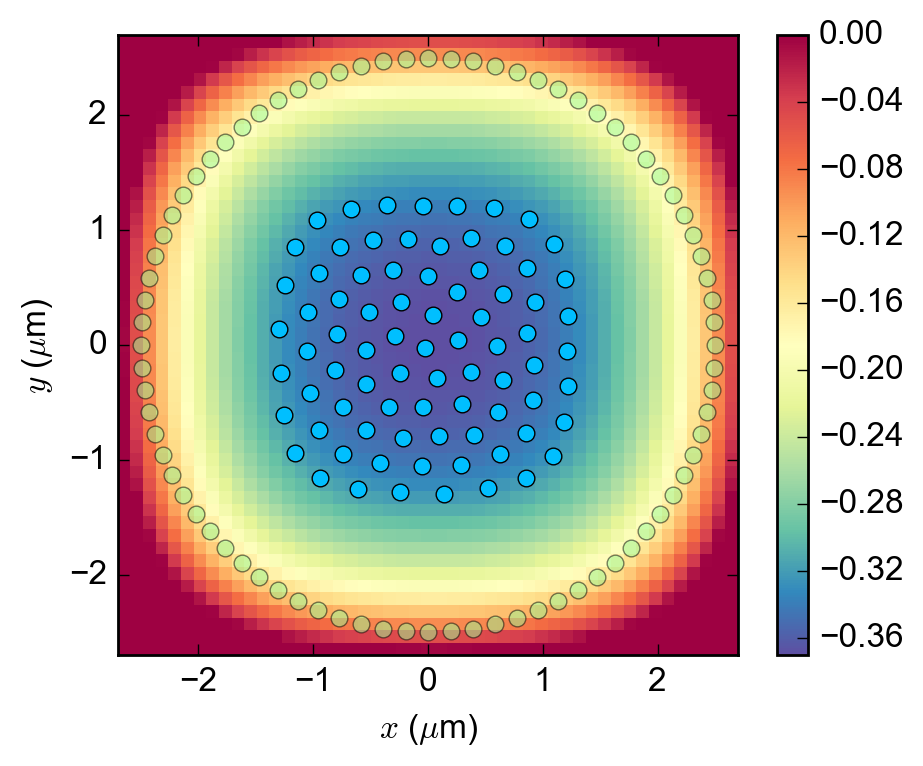

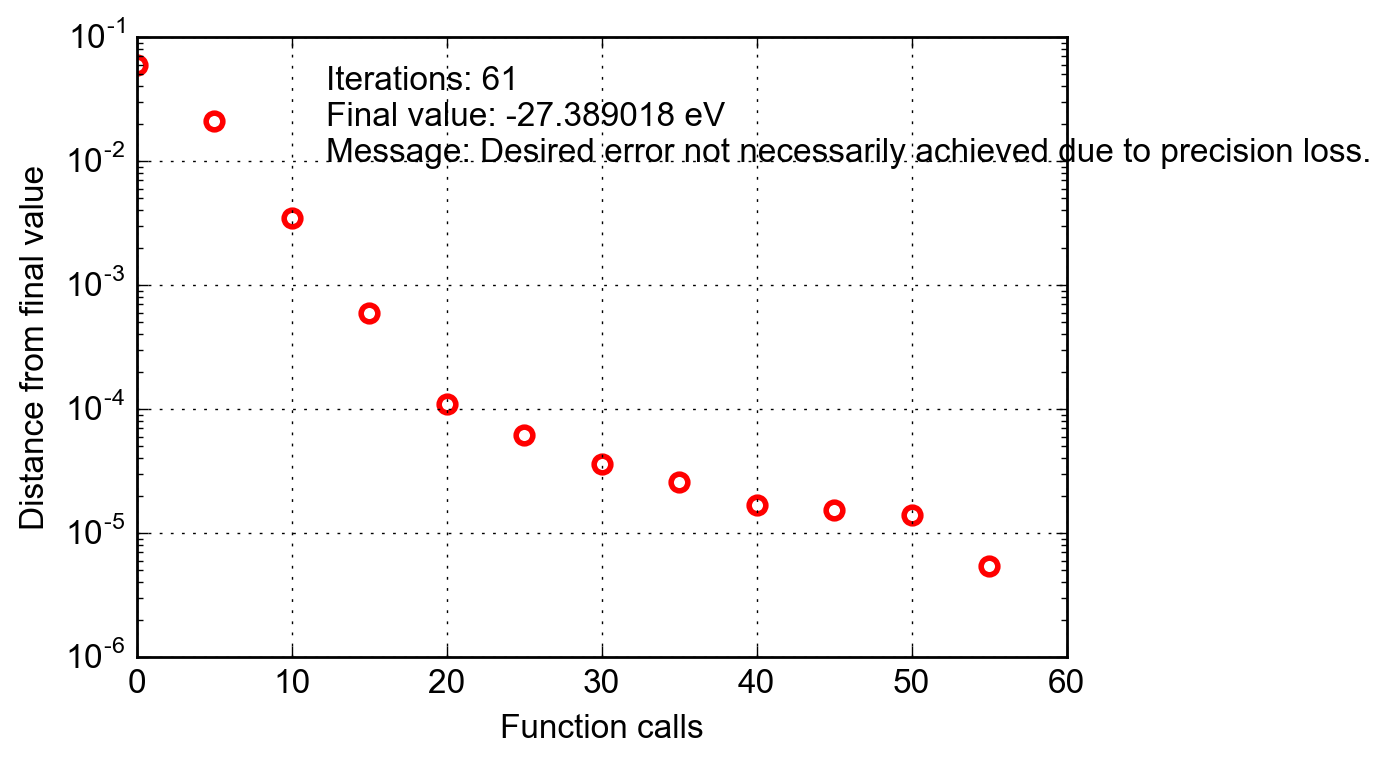

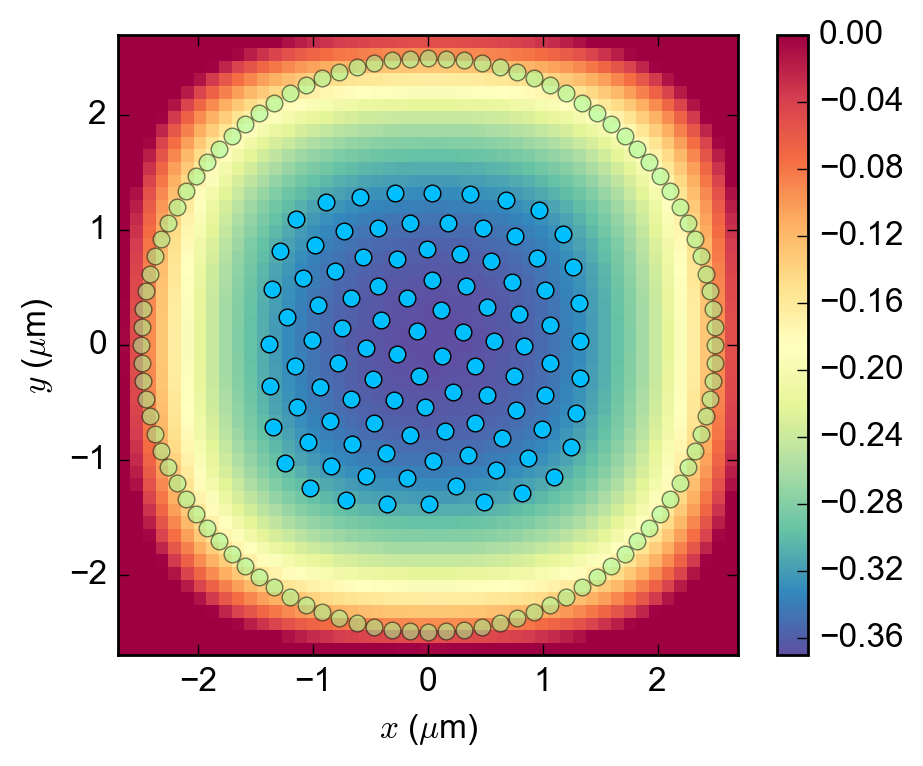

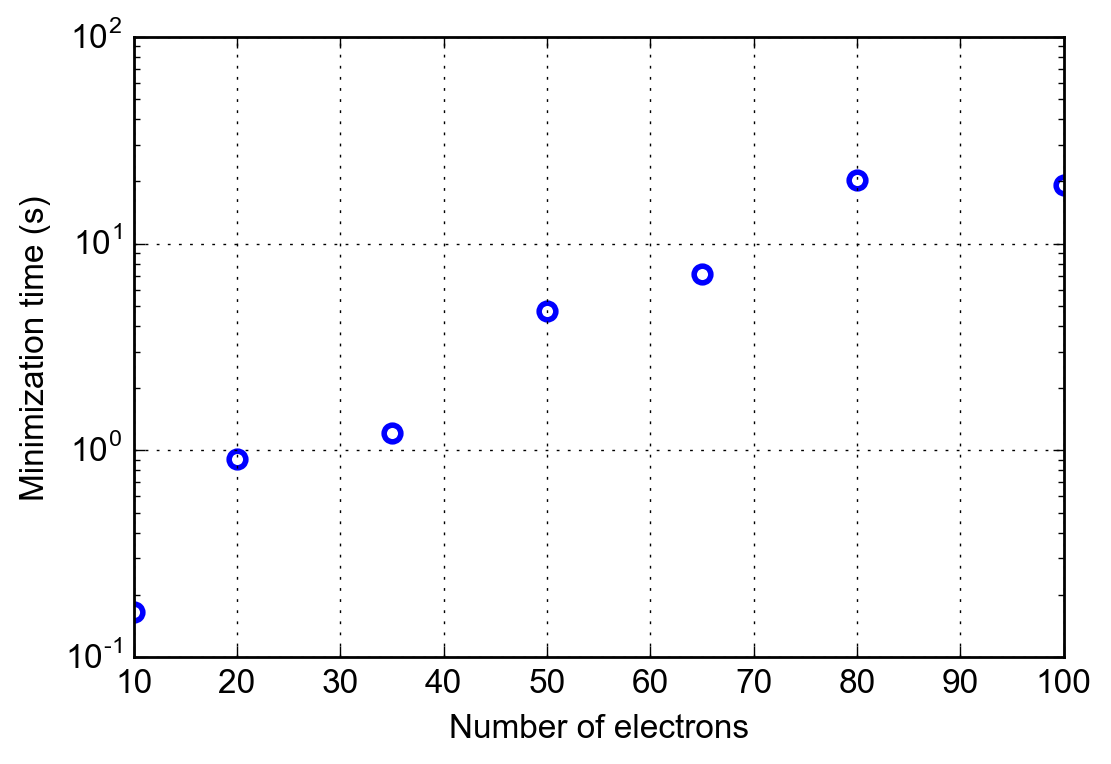

In [224]:
t = diagnose.Timer()
save = True
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Benchmark"

N_e = [10, 20, 35, 50, 65, 80, 100]
times = list()
iterations = list()

for N_electrons in N_e:
    initial_radius = 2.5E-6

    xinit = initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/N_electrons)
    yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/N_electrons)
    electron_initial_positions = xy2r(xinit, yinit)
    
    ConvMon = ConvergenceMonitor(verbose=False, N=5)
    
    t.tic()
    res = minimize(Vtotal, electron_initial_positions, method='CG', 
                   options={'disp': True, 'maxiter' : 1E6}, tol=1E-6, 
                   callback=ConvMon.monitor_convergence)
    t.toc()
    t.save("N_electrons : %.d"%N_electrons)
    
    times.append(t.get_elapsed_time())
    iterations.append(res['nit'])
    
    if 1: 
        x, y = r2xy(res['x'])

        figgy = plt.figure(figsize=(6.,4.))
        common.configure_axes(12)
        plt.plot(ConvMon.func_calls, np.abs((np.array(ConvMon.curr_func_val) - res['fun'])/res['fun']), 
                 'o', **common.plot_opt('red', style='translucent'))
        plt.xlabel("Function calls")
        plt.ylabel("Distance from final value")
        plt.yscale('log')
        plt.text(0.2*res['nit'], np.abs((ConvMon.curr_func_val[0] - res['fun'])/res['fun']), 
                 "Iterations: %d\nFinal value: %.6f eV\nMessage: %s"%(res['nit'], res['fun'], res['message']), 
                 wrap=True, ha='left', va='top')
        plt.grid()

        if save: 
            common.save_figure(figgy, save_path=save_path)
            
    if 1:
        figgy = plt.figure(figsize=(5,4))
        common.configure_axes(12)
        plt.pcolormesh(X*1E6, Y*1E6, Vext(X,Y)/gc['e'], cmap=plt.cm.Spectral_r, vmax=0.0)
        plt.plot(x*1E6, y*1E6, 'o', color='deepskyblue')
        plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
        plt.xlim(-2.7, 2.7)
        plt.ylim(plt.xlim())
        #plt.axes().set_aspect('equal', 'datalim')
        plt.xlabel("$x$ ($\mu$m)")
        plt.ylabel("$y$ ($\mu$m)")
        plt.colorbar()

        if save: 
            common.save_figure(figgy, save_path=save_path)

t.report()

figgy = plt.figure(figsize=(6.,4.))
plt.plot(N_e, times, 'o', **common.plot_opt('b', style='translucent'))
plt.yscale('log')
plt.xlabel("Number of electrons")
plt.ylabel("Minimization time (s)")
plt.grid()

if save: 
    common.save_figure(figgy, save_path=save_path)